In [1]:
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
from scipy.spatial import distance
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.sparse.csgraph import shortest_path
import scipy.sparse.linalg as ll
%matplotlib inline
import util
import sys
import time

In [2]:
### GET DATA -- IMAGE SHRINK IS NONE

ROOT_FOLDER = util.ROOT_FOLDER

filenames, datamap = util.initial_setup()

start = time.time()
# img_shrink = (75, 75)
img_shrink = None
datamap = util.data_setup(datamap, reduce=True, img_reduction=(2,2),img_shrink=img_shrink)
mid = time.time()


In [3]:
# Get picture array
arr = datamap['flattened_arr'].to_numpy()
cl = datamap['Class'].to_numpy()

row = arr.shape[0]
col = arr[0].shape[0]

arr = np.concatenate(arr, axis=0).reshape(33630,col)
image_arr = util.get_picture_array(arr, cl)

dimensions = datamap.Shape.iloc[0]
end = time.time()

In [4]:
print("Total Time:", end-start)
print("First Block Run Time:", mid - start)
print("Second Block Run Time:", end - mid)

Total Time: 20.966925621032715
First Block Run Time: 13.945246696472168
Second Block Run Time: 7.021678924560547


In [5]:
datamap.info(memory_usage="deep")
datamap

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33630 entries, 0 to 67809
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   File Name      33630 non-null  object
 1   Class          33630 non-null  int64 
 2   label          33630 non-null  object
 3   PhotoIncluded  33630 non-null  int64 
 4   Full Path      33630 non-null  object
 5   Raw Data       33630 non-null  object
 6   Shape          33630 non-null  object
 7   flattened_arr  33630 non-null  object
dtypes: int64(2), object(6)
memory usage: 29.1 MB


,File Name,Class,label,PhotoIncluded,Full Path,Raw Data,Shape,flattened_arr
0,ESP_013049_0950_RED-0067.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[198, 195, 192, 195, 202, 198, 184, 171, 166,...","(225, 225)","[198, 195, 192, 195, 202, 198, 184, 171, 166, ..."
1,ESP_013049_0950_RED-0067-fv.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[191, 190, 187, 185, 186, 186, 184, 184, 184,...","(225, 225)","[191, 190, 187, 185, 186, 186, 184, 184, 184, ..."
2,ESP_013049_0950_RED-0067-brt.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[223, 222, 218, 220, 226, 223, 213, 208, 202,...","(225, 225)","[223, 222, 218, 220, 226, 223, 213, 208, 202, ..."
3,ESP_013049_0950_RED-0067-r90.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[192, 190, 190, 189, 187, 185, 184, 185, 189,...","(225, 225)","[192, 190, 190, 189, 187, 185, 184, 185, 189, ..."
5,ESP_013049_0950_RED-0067-r270.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[170, 177, 189, 199, 206, 201, 185, 175, 173,...","(225, 225)","[170, 177, 189, 199, 206, 201, 185, 175, 173, ..."
...,...,...,...,...,...,...,...,...
67802,ESP_018707_2205_RED-0034.jpg,0,test,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(225, 225)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
67803,ESP_018707_2205_RED-0019.jpg,0,test,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[99, 104, 108, 105, 122, 159, 152, 125, 87, 8...","(225, 225)","[99, 104, 108, 105, 122, 159, 152, 125, 87, 86..."
67804,ESP_018707_2205_RED-0032.jpg,0,test,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[117, 118, 121, 117, 94, 68, 70, 92, 117, 137...","(225, 225)","[117, 118, 121, 117, 94, 68, 70, 92, 117, 137,..."
67805,ESP_018707_2205_RED-0041.jpg,0,test,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[161, 144, 107, 83, 89, 102, 110, 119, 133, 1...","(225, 225)","[161, 144, 107, 83, 89, 102, 110, 119, 133, 14..."


In [6]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))/1000000000) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('image_arr', 13.62041916),
 ('datamap', 0.030465204),
 ('filenames', 0.000277336),
 ('AnnotationBbox', 1.064e-06),
 ('OffsetImage', 1.064e-06),
 ('ROOT_FOLDER', 3.39e-07),
 ('arr', 1.2e-07),
 ('cl', 1.04e-07),
 ('distance', 7.2e-08),
 ('ll', 7.2e-08),
 ('np', 7.2e-08),
 ('plt', 7.2e-08),
 ('shortest_path', 7.2e-08),
 ('spio', 7.2e-08),
 ('dimensions', 5.6e-08),
 ('col', 2.8e-08),
 ('row', 2.8e-08),
 ('end', 2.4e-08),
 ('mid', 2.4e-08),
 ('start', 2.4e-08),
 ('img_shrink', 1.6e-08)]

In [7]:
arr.dtype

dtype('uint8')

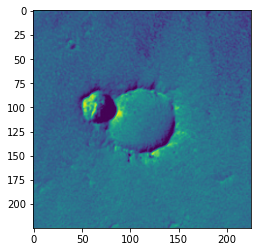

In [8]:
#############################################################################
# Alright lets review our image_arr file and how we can bring down its size #
#############################################################################

# Test Image
util.show_image(image_arr[9][:-1].reshape(dimensions))

Before 13620419160
After: 6810209640


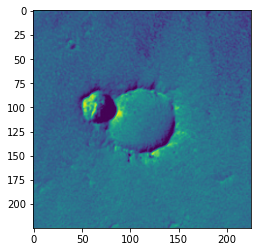

In [9]:
# Lets Reduce it to int32
# Reduce the size of the array
print("Before", sys.getsizeof(image_arr))
image_arr = image_arr.astype(np.int32)
print("After:", sys.getsizeof(image_arr))

# Test Image
util.show_image(image_arr[9][:-1].reshape(dimensions))

Before 6810209640
After: 3405104880


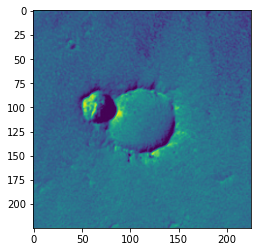

In [10]:
# Let's reduce it to int16
# Reduce the size of the array
print("Before", sys.getsizeof(image_arr))
image_arr = image_arr.astype(np.int16)
print("After:", sys.getsizeof(image_arr))

# Test Image
util.show_image(image_arr[9][:-1].reshape(dimensions))

In [11]:
# int8
# range is from -128 to 127
# Still keeps general idea of image but distorts the color

# Let's reduce it to int8
# Reduce the size of the array
# print("Before", sys.getsizeof(image_arr))
# image_arr = image_arr.astype(np.int8)
# print("After:", sys.getsizeof(image_arr))

# # Test Image
# util.show_image(image_arr[9][:-1].reshape(dimensions))

In [12]:
########################
# Some Image_arr facts #
########################

tmp = image_arr
print(f"Initial Size | Shape: {sys.getsizeof(tmp)} | {tmp.shape}")

tmp = image_arr[0]
print(f"Size/Shape of first row (just slice): {sys.getsizeof(tmp)} | {tmp.shape}")

tmp = image_arr[0].copy()
print(f"Size/Shape of first row (copy): {sys.getsizeof(tmp)} | {tmp.shape}")

tmp = image_arr[1].copy()
print(f"Size/Shape of second row (copy): {sys.getsizeof(tmp)} | {tmp.shape}")

tmp = image_arr[0][:-1].reshape(dimensions)
print(f"Size/Shape of first row reshaped (just slice): {sys.getsizeof(tmp)} | {tmp.shape}")

tmp = image_arr[0][:-1].reshape(dimensions).copy()
print(f"Size/Shape of first row reshaped (copy): {sys.getsizeof(tmp)} | {tmp.shape}")

tmp = image_arr[0:2]
print(f"Size/Shape of first two rows (slice): {sys.getsizeof(tmp)} | {tmp.shape}")

tmp = image_arr[0:2].copy()
print(f"Size/Shape of first two rows (copy): {sys.getsizeof(tmp)} | {tmp.shape}")

tmp = image_arr[0:3].copy()
print(f"Size/Shape of first three rows (copy): {sys.getsizeof(tmp)} | {tmp.shape}")
# print(len(image_arr[0:2][1]))

tmp = image_arr[0:4].copy()
print(f"Size/Shape of first four rows (copy): {sys.getsizeof(tmp)} | {tmp.shape}")


##### Roughly 2 bytes per number so 51530*33630*2 = 3468999600

Initial Size | Shape: 3405104880 | (33630, 50626)
Size/Shape of first row (just slice): 104 | (50626,)
Size/Shape of first row (copy): 101356 | (50626,)
Size/Shape of second row (copy): 101356 | (50626,)
Size/Shape of first row reshaped (just slice): 120 | (225, 225)
Size/Shape of first row reshaped (copy): 101370 | (225, 225)
Size/Shape of first two rows (slice): 120 | (2, 50626)
Size/Shape of first two rows (copy): 202624 | (2, 50626)
Size/Shape of first three rows (copy): 303876 | (3, 50626)
Size/Shape of first four rows (copy): 405128 | (4, 50626)


In [13]:
################################################
# Alright Lets explore image compression ideas #
################################################

### GET DATA -- IMAGE SHRINK IS NONE

ROOT_FOLDER = util.ROOT_FOLDER

filenames, datamap_b = util.initial_setup()

start_b = time.time()
img_shrink = (75, 75) # 25, 45, 75
# img_shrink = None

datamap_b = util.data_setup(datamap_b, reduce=True, img_reduction=(2,2),img_shrink=img_shrink)
mid_b = time.time()


In [14]:
# Get picture array
arr_b = datamap_b['flattened_arr'].to_numpy()
cl_b = datamap_b['Class'].to_numpy()

row_b = arr_b.shape[0]
col_b = arr_b[0].shape[0]

arr_b = np.concatenate(arr_b, axis=0).reshape(33630,col_b)
image_arr_b = util.get_picture_array(arr_b, cl_b)

dimensions_b = datamap_b.Shape.iloc[0]
end_b = time.time()

In [15]:
print("Total Time:", end_b-start_b)
print("First Block Run Time:", mid_b - start_b)
print("Second Block Run Time:", end_b - mid_b)

Total Time: 83.62363839149475
First Block Run Time: 83.00831151008606
Second Block Run Time: 0.6153268814086914


In [16]:
datamap_b.info(memory_usage="deep")
datamap_b

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33630 entries, 0 to 67809
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   File Name      33630 non-null  object
 1   Class          33630 non-null  int64 
 2   label          33630 non-null  object
 3   PhotoIncluded  33630 non-null  int64 
 4   Full Path      33630 non-null  object
 5   Raw Data       33630 non-null  object
 6   Shape          33630 non-null  object
 7   flattened_arr  33630 non-null  object
dtypes: int64(2), object(6)
memory usage: 389.9 MB


,File Name,Class,label,PhotoIncluded,Full Path,Raw Data,Shape,flattened_arr
0,ESP_013049_0950_RED-0067.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[1719, 1835, 1617, 1564, 1658, 1666, 1684, 16...","(75, 75)","[1719, 1835, 1617, 1564, 1658, 1666, 1684, 166..."
1,ESP_013049_0950_RED-0067-fv.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[1697, 1670, 1672, 1739, 1719, 1709, 1700, 16...","(75, 75)","[1697, 1670, 1672, 1739, 1719, 1709, 1700, 168..."
2,ESP_013049_0950_RED-0067-brt.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[1962, 2035, 1898, 1859, 1921, 1927, 1940, 19...","(75, 75)","[1962, 2035, 1898, 1859, 1921, 1927, 1940, 192..."
3,ESP_013049_0950_RED-0067-r90.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[1698, 1671, 1687, 1664, 1628, 1642, 1683, 16...","(75, 75)","[1698, 1671, 1687, 1664, 1628, 1642, 1683, 165..."
5,ESP_013049_0950_RED-0067-r270.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[1624, 1779, 1645, 1660, 1726, 1724, 1662, 16...","(75, 75)","[1624, 1779, 1645, 1660, 1726, 1724, 1662, 168..."
...,...,...,...,...,...,...,...,...
67802,ESP_018707_2205_RED-0034.jpg,0,test,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(75, 75)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
67803,ESP_018707_2205_RED-0019.jpg,0,test,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[886, 1130, 1157, 1074, 1090, 1075, 1025, 109...","(75, 75)","[886, 1130, 1157, 1074, 1090, 1075, 1025, 1098..."
67804,ESP_018707_2205_RED-0032.jpg,0,test,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[1135, 882, 787, 1222, 1047, 1040, 1090, 1178...","(75, 75)","[1135, 882, 787, 1222, 1047, 1040, 1090, 1178,..."
67805,ESP_018707_2205_RED-0041.jpg,0,test,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[1238, 828, 1085, 1318, 1305, 1151, 1154, 120...","(75, 75)","[1238, 828, 1085, 1318, 1305, 1151, 1154, 1206..."


In [17]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))/1000000000) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('image_arr', 3.40510488),
 ('image_arr_b', 1.51361916),
 ('datamap_b', 0.408802704),
 ('datamap', 0.030465204),
 ('tmp', 0.000405128),
 ('filenames', 0.000277336),
 ('AnnotationBbox', 1.064e-06),
 ('OffsetImage', 1.064e-06),
 ('ROOT_FOLDER', 3.39e-07),
 ('arr', 1.2e-07),
 ('arr_b', 1.2e-07),
 ('cl', 1.04e-07),
 ('cl_b', 1.04e-07),
 ('distance', 7.2e-08),
 ('ll', 7.2e-08),
 ('np', 7.2e-08),
 ('plt', 7.2e-08),
 ('shortest_path', 7.2e-08),
 ('spio', 7.2e-08),
 ('dimensions', 5.6e-08),
 ('dimensions_b', 5.6e-08),
 ('img_shrink', 5.6e-08),
 ('col', 2.8e-08),
 ('col_b', 2.8e-08),
 ('row', 2.8e-08),
 ('row_b', 2.8e-08),
 ('end', 2.4e-08),
 ('end_b', 2.4e-08),
 ('mid', 2.4e-08),
 ('mid_b', 2.4e-08),
 ('start', 2.4e-08),
 ('start_b', 2.4e-08)]

In [18]:
((arr_b.shape[0] * arr_b[0].shape[0]) * 2) / 1e9

0.3783375

In [19]:
################################################
# ROUND 3 -- lets reduce it even further 45x45 #
################################################

In [20]:
### GET DATA -- IMAGE SHRINK IS 45

ROOT_FOLDER = util.ROOT_FOLDER

filenames, datamap_c = util.initial_setup()

start_c = time.time()
img_shrink = (45, 45) # 25, 45, 75
# img_shrink = None

datamap_c = util.data_setup(datamap_c, reduce=True, img_reduction=(2,2),img_shrink=img_shrink)
mid_c = time.time()

In [21]:
# Get picture array
arr_c = datamap_c['flattened_arr'].to_numpy()
cl_c = datamap_c['Class'].to_numpy()

row_c = arr_c.shape[0]
col_c = arr_c[0].shape[0]

arr_c = np.concatenate(arr_c, axis=0).reshape(33630,col_c)
image_arr_c = util.get_picture_array(arr_c, cl_c)

dimensions_c = datamap_c.Shape.iloc[0]
end_c = time.time()

In [22]:
print("Total Time:", end_c-start_c)
print("First Block Run Time:", mid_c - start_c)
print("Second Block Run Time:", end_c - mid_c)

Total Time: 16.784945726394653
First Block Run Time: 16.560933113098145
Second Block Run Time: 0.2240126132965088


In [23]:
datamap_c.info(memory_usage="deep")
datamap_c

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33630 entries, 0 to 67809
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   File Name      33630 non-null  object
 1   Class          33630 non-null  int64 
 2   label          33630 non-null  object
 3   PhotoIncluded  33630 non-null  int64 
 4   Full Path      33630 non-null  object
 5   Raw Data       33630 non-null  object
 6   Shape          33630 non-null  object
 7   flattened_arr  33630 non-null  object
dtypes: int64(2), object(6)
memory usage: 158.9 MB


,File Name,Class,label,PhotoIncluded,Full Path,Raw Data,Shape,flattened_arr
0,ESP_013049_0950_RED-0067.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[4833, 4683, 4575, 4691, 4572, 4483, 4684, 47...","(45, 45)","[4833, 4683, 4575, 4691, 4572, 4483, 4684, 479..."
1,ESP_013049_0950_RED-0067-fv.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[4672, 4688, 4753, 4762, 4741, 4596, 4876, 46...","(45, 45)","[4672, 4688, 4753, 4762, 4741, 4596, 4876, 467..."
2,ESP_013049_0950_RED-0067-brt.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[5484, 5386, 5314, 5394, 5321, 5260, 5387, 54...","(45, 45)","[5484, 5386, 5314, 5394, 5321, 5260, 5387, 545..."
3,ESP_013049_0950_RED-0067-r90.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[4673, 4686, 4528, 4595, 4575, 4688, 4747, 46...","(45, 45)","[4673, 4686, 4528, 4595, 4575, 4688, 4747, 467..."
5,ESP_013049_0950_RED-0067-r270.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[4668, 4682, 4747, 4682, 4673, 4744, 4647, 45...","(45, 45)","[4668, 4682, 4747, 4682, 4673, 4744, 4647, 452..."
...,...,...,...,...,...,...,...,...
67802,ESP_018707_2205_RED-0034.jpg,0,test,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 765, 3311, ...","(45, 45)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 765, 3311, 3..."
67803,ESP_018707_2205_RED-0019.jpg,0,test,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[2625, 3248, 3117, 2992, 2890, 3164, 3100, 25...","(45, 45)","[2625, 3248, 3117, 2992, 2890, 3164, 3100, 254..."
67804,ESP_018707_2205_RED-0032.jpg,0,test,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[3148, 2261, 3111, 3107, 3027, 2911, 2882, 30...","(45, 45)","[3148, 2261, 3111, 3107, 3027, 2911, 2882, 305..."
67805,ESP_018707_2205_RED-0041.jpg,0,test,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[2980, 3010, 3716, 3267, 3298, 3190, 3636, 32...","(45, 45)","[2980, 3010, 3716, 3267, 3298, 3190, 3636, 322..."


In [24]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))/1000000000) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('image_arr', 3.40510488),
 ('image_arr_b', 1.51361916),
 ('image_arr_c', 0.54507516),
 ('datamap_b', 0.408802704),
 ('datamap_c', 0.166666704),
 ('datamap', 0.030465204),
 ('tmp', 0.000405128),
 ('filenames', 0.000277336),
 ('AnnotationBbox', 1.064e-06),
 ('OffsetImage', 1.064e-06),
 ('ROOT_FOLDER', 3.39e-07),
 ('arr', 1.2e-07),
 ('arr_b', 1.2e-07),
 ('arr_c', 1.2e-07),
 ('cl', 1.04e-07),
 ('cl_b', 1.04e-07),
 ('cl_c', 1.04e-07),
 ('distance', 7.2e-08),
 ('ll', 7.2e-08),
 ('np', 7.2e-08),
 ('plt', 7.2e-08),
 ('shortest_path', 7.2e-08),
 ('spio', 7.2e-08),
 ('dimensions', 5.6e-08),
 ('dimensions_b', 5.6e-08),
 ('dimensions_c', 5.6e-08),
 ('img_shrink', 5.6e-08),
 ('col', 2.8e-08),
 ('col_b', 2.8e-08),
 ('col_c', 2.8e-08),
 ('row', 2.8e-08),
 ('row_b', 2.8e-08),
 ('row_c', 2.8e-08),
 ('end', 2.4e-08),
 ('end_b', 2.4e-08),
 ('end_c', 2.4e-08),
 ('mid', 2.4e-08),
 ('mid_b', 2.4e-08),
 ('mid_c', 2.4e-08),
 ('start', 2.4e-08),
 ('start_b', 2.4e-08),
 ('start_c', 2.4e-08)]

In [25]:
################################################
# ROUND 4 -- lets reduce it even further 45x45 #
################################################

In [26]:
### GET DATA -- IMAGE SHRINK IS 45

ROOT_FOLDER = util.ROOT_FOLDER

filenames, datamap_d = util.initial_setup()

start_d = time.time()
img_shrink = (25, 25) # 25, 45, 75
# img_shrink = None

datamap_d = util.data_setup(datamap_d, reduce=True, img_reduction=(2,2),img_shrink=img_shrink)
mid_d = time.time()

In [27]:
# Get picture array
arr_d = datamap_d['flattened_arr'].to_numpy()
cl_d = datamap_d['Class'].to_numpy()

row_d = arr_d.shape[0]
col_d = arr_d[0].shape[0]

arr_d = np.concatenate(arr_d, axis=0).reshape(33630,col_d)
image_arr_d = util.get_picture_array(arr_d, cl_d)

dimensions_d = datamap_d.Shape.iloc[0]
end_d = time.time()

In [28]:
print("Total Time:", end_d-start_d)
print("First Block Run Time:", mid_d - start_d)
print("Second Block Run Time:", end_d - mid_d)

Total Time: 16.227565050125122
First Block Run Time: 16.12287735939026
Second Block Run Time: 0.10468769073486328


In [29]:
datamap_d.info(memory_usage="deep")
datamap_d

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33630 entries, 0 to 67809
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   File Name      33630 non-null  object
 1   Class          33630 non-null  int64 
 2   label          33630 non-null  object
 3   PhotoIncluded  33630 non-null  int64 
 4   Full Path      33630 non-null  object
 5   Raw Data       33630 non-null  object
 6   Shape          33630 non-null  object
 7   flattened_arr  33630 non-null  object
dtypes: int64(2), object(6)
memory usage: 69.1 MB


,File Name,Class,label,PhotoIncluded,Full Path,Raw Data,Shape,flattened_arr
0,ESP_013049_0950_RED-0067.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[15780, 15019, 14767, 14957, 15262, 14837, 11...","(25, 25)","[15780, 15019, 14767, 14957, 15262, 14837, 118..."
1,ESP_013049_0950_RED-0067-fv.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[15167, 15407, 15451, 15408, 15110, 15139, 14...","(25, 25)","[15167, 15407, 15451, 15408, 15110, 15139, 143..."
2,ESP_013049_0950_RED-0067-brt.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[17827, 17344, 17206, 17315, 17517, 17249, 15...","(25, 25)","[17827, 17344, 17206, 17315, 17517, 17249, 151..."
3,ESP_013049_0950_RED-0067-r90.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[15166, 14611, 14155, 15003, 14764, 16031, 15...","(25, 25)","[15166, 14611, 14155, 15003, 14764, 16031, 154..."
5,ESP_013049_0950_RED-0067-r270.jpg,7,train,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[15034, 15333, 14935, 14819, 14283, 13985, 15...","(25, 25)","[15034, 15333, 14935, 14819, 14283, 13985, 150..."
...,...,...,...,...,...,...,...,...
67802,ESP_018707_2205_RED-0034.jpg,0,test,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[0, 0, 0, 0, 0, 0, 4698, 10539, 10221, 10559,...","(25, 25)","[0, 0, 0, 0, 0, 0, 4698, 10539, 10221, 10559, ..."
67803,ESP_018707_2205_RED-0019.jpg,0,test,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[9836, 9861, 9565, 9679, 9125, 8928, 9557, 98...","(25, 25)","[9836, 9861, 9565, 9679, 9125, 8928, 9557, 984..."
67804,ESP_018707_2205_RED-0032.jpg,0,test,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[9286, 9922, 9822, 9884, 10043, 10708, 9361, ...","(25, 25)","[9286, 9922, 9822, 9884, 10043, 10708, 9361, 1..."
67805,ESP_018707_2205_RED-0041.jpg,0,test,1,C:\Users\cdcro\Documents\GT\Project\Mars\hiris...,"[[9600, 11770, 10662, 10897, 9923, 9922, 9655,...","(25, 25)","[9600, 11770, 10662, 10897, 9923, 9922, 9655, ..."


In [30]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))/1000000000) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('image_arr', 3.40510488),
 ('image_arr_b', 1.51361916),
 ('image_arr_c', 0.54507516),
 ('datamap_b', 0.408802704),
 ('image_arr_d', 0.16841916),
 ('datamap_c', 0.166666704),
 ('datamap_d', 0.072502704),
 ('datamap', 0.030465204),
 ('tmp', 0.000405128),
 ('filenames', 0.000277336),
 ('AnnotationBbox', 1.064e-06),
 ('OffsetImage', 1.064e-06),
 ('ROOT_FOLDER', 3.39e-07),
 ('arr', 1.2e-07),
 ('arr_b', 1.2e-07),
 ('arr_c', 1.2e-07),
 ('arr_d', 1.2e-07),
 ('cl', 1.04e-07),
 ('cl_b', 1.04e-07),
 ('cl_c', 1.04e-07),
 ('cl_d', 1.04e-07),
 ('distance', 7.2e-08),
 ('ll', 7.2e-08),
 ('np', 7.2e-08),
 ('plt', 7.2e-08),
 ('shortest_path', 7.2e-08),
 ('spio', 7.2e-08),
 ('dimensions', 5.6e-08),
 ('dimensions_b', 5.6e-08),
 ('dimensions_c', 5.6e-08),
 ('dimensions_d', 5.6e-08),
 ('img_shrink', 5.6e-08),
 ('col', 2.8e-08),
 ('col_b', 2.8e-08),
 ('col_c', 2.8e-08),
 ('col_d', 2.8e-08),
 ('row', 2.8e-08),
 ('row_b', 2.8e-08),
 ('row_c', 2.8e-08),
 ('row_d', 2.8e-08),
 ('end', 2.4e-08),
 ('end_b', 2.4e-

In [31]:
######################
# COMPARE THE IMAGES #
######################

Original Image
Dimensions 225x225 | Size: 101370


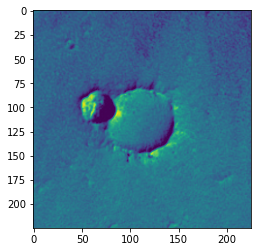

In [32]:
image_ex = image_arr[9][1:].reshape(225,225).copy()
image_ex_b = image_arr_b[9][1:].reshape(75,75).copy()
image_ex_c = image_arr_c[9][1:].reshape(45,45).copy()
image_ex_d = image_arr_d[9][1:].reshape(25,25).copy()

print("Original Image")
print("Dimensions 225x225 | Size:", sys.getsizeof(image_ex))
plt.imshow(image_ex)

Compressed Image 75x75
Dimensions 75x75 | Size: 45120


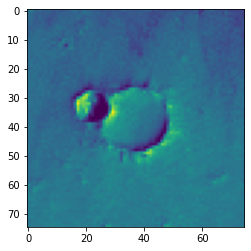

In [33]:
print("Compressed Image 75x75")
print("Dimensions 75x75 | Size:", sys.getsizeof(image_ex_b))
plt.imshow(image_ex_b)

Compressed Image 45x45
Dimensions 45x45 | Size: 16320


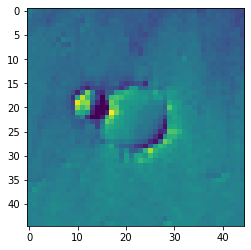

In [34]:
print("Compressed Image 45x45")
print("Dimensions 45x45 | Size:", sys.getsizeof(image_ex_c))
plt.imshow(image_ex_c)

Compressed Image 25x25
Dimensions 25x25 | Size: 5120


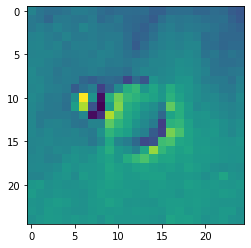

In [35]:
print("Compressed Image 25x25")
print("Dimensions 25x25 | Size:", sys.getsizeof(image_ex_d))
plt.imshow(image_ex_d)

In [38]:
def get_compressed_data(compression=(75,75), debug=False):
    ### GET DATA -- IMAGE SHRINK IS 45
    
    start = time.time()
    ROOT_FOLDER = util.ROOT_FOLDER

    filenames, datamap = util.initial_setup()

    
    # A
    mid_a = time.time()
    datamap = util.data_setup(datamap, reduce=True, img_reduction=(2,2),img_shrink=compression)
 
    # B
    mid_b = time.time()
    # Get picture array
    arr = datamap['flattened_arr'].to_numpy()
    cd = datamap['Class'].to_numpy()

    row = arr.shape[0]
    col = arr[0].shape[0]

    arr = np.concatenate(arr, axis=0).reshape(row,col)
    image_arr = util.get_picture_array(arr, cl)

    dimensions = datamap.Shape.iloc[0]
    end = time.time()
    
    if debug:
        print("Total Time:", end-start)
        print("Initial SetUp Time:", mid_a - start)
        print("Datamap Time (A):", mid_b - mid_a)
        print("Image Arr Time (B):", end - mid_b)
        
        # These are the usual ipython objects, including this one you are creating
        ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

        # Get a sorted list of the objects and their sizes
        print(sorted([(x, sys.getsizeof(globals().get(x))/1000000000) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True))
        
    return datamap, image_arr
        
